# SberMarket Competition
Having a history of previous orders predict whether an item will be in the next customer basket.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv').rename(columns={'cart': 'product_id'})

In [3]:
data.head()

,user_id,order_completed_at,product_id
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


## Prepare data and key features
- creating order id
- parsing dates
- creating order df with unique order sets
- creating reordered feature
- creating days since prior order feature

Create order id based on user id and order completetion time.

In [4]:
data = data.merge(
    data
    .groupby(['user_id', 'order_completed_at'], as_index=False)
    .count()
    .loc[:, ['user_id', 'order_completed_at']]
    .reset_index()
    .rename(columns={'index': 'order_id'}),
    how='left',
    on=['user_id', 'order_completed_at']
).rename(columns={'cart': 'product_id'})

Parse dates.

In [5]:
data['order_completed_at'] = pd.to_datetime(data.order_completed_at)
data['hour_of_order'] = data.order_completed_at.dt.hour
data['day_of_order'] = data.order_completed_at.dt.day
data['weekday_of_order'] = data.order_completed_at.dt.weekday
data['month_of_order'] = data.order_completed_at.dt.month

Create orders data frame with a set of categories for each order. Add order number for each user.

In [6]:
orders = (
    data
    .groupby(['user_id', 'order_id'], as_index=False)
    .agg({'product_id': lambda x: list(set(x))})
    .rename(columns={'product_id': 'cart'})
)

Mark last orders for each user.

In [8]:
last_orders_by_group = orders.groupby('user_id').nth(-1).order_id

last_order_df = pd.DataFrame(
    {
        'order_id': last_orders_by_group,
        'last_order': [True for _ in range(last_orders_by_group.shape[0])]
    }
)

orders = orders.merge(last_order_df, how='left', on='order_id').fillna(False)

Iterate through user groups and check if the item was reordered in the next cart.

In [9]:
reordered = []

for group_name, grouped_df in orders.groupby('user_id'):
    for row_idx, row in grouped_df.iterrows():
        if not row.last_order:
            reordered.extend(
                pd.Series(row.cart).isin(grouped_df.loc[row_idx + 1, 'cart']).tolist()
            )
        else:
            reordered.extend([None for _ in row.cart])
            
data['reordered'] = reordered

Getting days since prior order for each user.

In [11]:
data = data.merge(
    data
    .groupby(['user_id', 'order_id'], as_index=False)
    .nth(0)
    .set_index('order_id')
    .groupby('user_id')
    .apply(lambda grouped_df: grouped_df.order_completed_at.diff().dt.days)
    .reset_index()
    .rename(columns={'order_completed_at': 'days_since_prior_order'}),
    how='left',
    on=['user_id', 'order_id']
)

In [12]:
data.head()

,user_id,order_completed_at,product_id,order_id,hour_of_order,day_of_order,weekday_of_order,month_of_order,reordered,days_since_prior_order
0,2,2015-03-22 09:25:46,399,12,9,22,6,3,True,NaN
1,2,2015-03-22 09:25:46,14,12,9,22,6,3,False,NaN
2,2,2015-03-22 09:25:46,198,12,9,22,6,3,True,NaN
3,2,2015-03-22 09:25:46,88,12,9,22,6,3,False,NaN
4,2,2015-03-22 09:25:46,157,12,9,22,6,3,True,NaN


## Exploratory Data Analysis

When do people order?

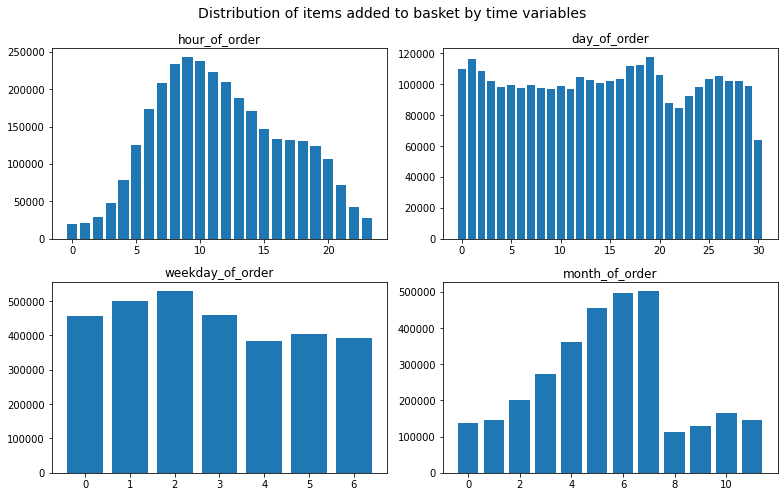

In [13]:
f, axs = plt.subplots(2, 2, figsize=(11, 7))

def plot_time(ax, time_period):
    ax.bar(range(data[time_period].nunique()), data[time_period].value_counts().sort_index())
    ax.set_title(time_period)
    return ax


plot_time(axs[0, 0], 'hour_of_order')
plot_time(axs[0, 1], 'day_of_order')
plot_time(axs[1, 0], 'weekday_of_order')
plot_time(axs[1, 1], 'month_of_order')

plt.suptitle('Distribution of items added to basket by time variables', fontsize=14)
plt.tight_layout()
plt.show()

The most notable differences could be observed on hourly graph. Most orders took place during the daytime, especially before lunch. People tend to order more on weekdays. Month distribution might be severely distorted due to rapid growth of e-grocery during the pandemic.

When do people buy again?

In [14]:
data.days_since_prior_order.value_counts().head(10)

6.0     230379
7.0     210188
5.0     183056
4.0     170410
3.0     160071
8.0     141878
2.0     130033
9.0     112581
10.0     95543
1.0      92595
Name: days_since_prior_order, dtype: int64

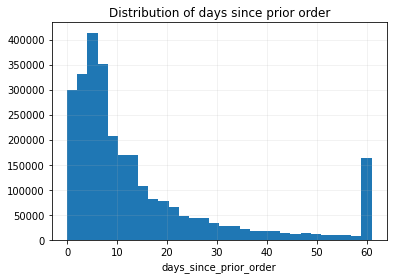

In [15]:
f, ax = plt.subplots()
hist_data = data.copy()
hist_data.loc[hist_data.days_since_prior_order > 61, :] = 61
hist_data.days_since_prior_order.hist(ax=ax, bins=30)
ax.set_xlabel('days_since_prior_order')
ax.set_title('Distribution of days since prior order')
ax.grid(alpha=0.2)
plt.show()

Most of reorders for each user seem to happen approximately in a week.

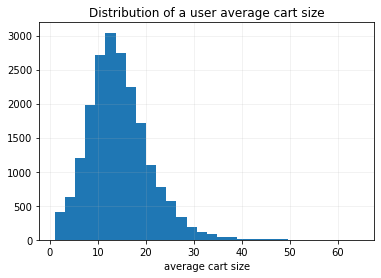

In [16]:
f, ax = plt.subplots()

(
    orders
    .groupby('user_id')
    .agg({'cart': lambda x: x.str.len().mean()})
    .hist(ax=ax, bins=30)
)

ax.set_xlabel('average cart size')
ax.set_title('Distribution of a user average cart size')
ax.grid(alpha=0.2)
plt.show()

Most users on average have 10-15 categories in their carts. 

## Feature engineering

### Products

In [17]:
products = (
    
#     calculate product order time for each user
    data
    .assign(
        product_time = data.groupby(['user_id', 'product_id']).cumcount() + 1
    )
    
#     calculate total product orders, product reorder ratio and product reorder prob
#     product average hour, day and weekday of order
    .groupby('product_id', as_index=False)
    .agg(
        product_first_time = ('product_time', lambda x: sum(x == 1)),
        product_second_time = ('product_time', lambda x: sum(x == 2)),
        total_product_orders = ('order_completed_at', 'count'),
        total_product_reorders = ('reordered', sum),
        avg_product_hour_of_order = ('hour_of_order', 'mean'),
        avg_product_weekday_of_order = ('weekday_of_order', 'mean'),
    )
    .replace({False: 0})
    .assign(
        product_reorder_ratio = lambda df: (df.total_product_reorders / df.total_product_orders).astype(float),
        product_reorder_prob = lambda df: (df.product_second_time / df.product_first_time).astype(float),
        product_reorder_times = lambda df: (1 + df.total_product_reorders / df.product_first_time).astype(float)
    )
    .drop(['total_product_reorders', 'product_first_time', 'product_second_time'], axis=1)
)

In [18]:
products.head()

,product_id,total_product_orders,avg_product_hour_of_order,avg_product_weekday_of_order,product_reorder_ratio,product_reorder_prob,product_reorder_times
0,0,18387,11.654158,2.854734,0.321586,0.470406,1.732169
1,1,357,11.890756,3.030812,0.366947,0.276498,1.603687
2,2,30,10.333333,3.333333,0.333333,0.160000,1.400000
3,3,1,8.000000,6.000000,0.000000,0.000000,1.000000
4,4,219,11.835616,2.767123,0.301370,0.115789,1.347368


### Users

In [19]:
users = (
    
#     adding user days since prior order and total days customer uses service
#     adding number of reordered items normalized on total user products, distinct products
    data
    .groupby('user_id', as_index=False)
    .agg(
        user_avg_days_spo = ('days_since_prior_order', 'mean'),
        user_reordered = ('reordered', sum),
        total_user_products = ('product_id', 'count'),
        user_distinct_products = ('product_id', lambda x: x.nunique()),
        avg_user_hour_of_order = ('hour_of_order', 'mean'),
        avg_user_weekday_of_order = ('weekday_of_order', 'mean'),
    )
    
#     adding total_user_days
    .merge(
        data
        .groupby(['user_id', 'order_id'], as_index=False)
        .nth(0)
        .groupby('user_id')
        .agg(user_total_days = ('days_since_prior_order', sum)),
        on='user_id',
        how='left'
    )
    
#     adding user total orders
    .merge(
        orders
        .groupby('user_id', as_index=False)
        .size(),
        on='user_id',
        how='left'
    )
    .rename(columns={'size': 'total_user_orders'})
    
#     calculating user reorder ratio, adding user average cart size
    .assign(
        user_reordered_ratio = lambda df: (df.user_reordered / df.total_user_products).astype(float),
        user_avg_cart_size = lambda df: df.total_user_products / df.total_user_orders
    )
    .drop('user_reordered', axis=1)
)

In [20]:
users.head()

,user_id,user_avg_days_spo,total_user_products,user_distinct_products,avg_user_hour_of_order,avg_user_weekday_of_order,user_total_days,total_user_orders,user_reordered_ratio,user_avg_cart_size
0,0,26.750000,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667
1,1,67.583333,37,20,11.567568,2.648649,427.0,9,0.378378,4.111111
2,2,206.519231,172,74,15.796512,3.767442,1909.0,15,0.331395,11.466667
3,3,601.918033,62,38,12.322581,4.161290,1829.0,7,0.274194,8.857143
4,4,268.381818,112,50,10.491071,3.803571,1874.0,8,0.312500,14.000000


### User-Product

In [21]:
user_product = (
    
#     creating user-product df and adding total orders of product by user
    data
    .groupby(['user_id', 'product_id'], as_index=False)
    .agg(
        user_product_total_orders = ('order_id', 'count'),
    )
    
#     adding users features
    .merge(
        users, how='left', on='user_id'
    )
    
#     adding products features
    .merge(
        products, how='left', on='product_id'
    )
    
#     adding rates for user-product
    .assign(
        up_order_rate = lambda df: df.user_product_total_orders / df.total_user_orders,
    )
    
#     adding target - in last cart - whether product was included in the last user's order
    .merge(
        orders
        .loc[orders.last_order == True, ['user_id', 'cart']],
        how='left',
        on='user_id'
    )
    .assign(
        in_last_cart = lambda df: df.apply(lambda row: row.product_id in row.cart, axis=1)
    )
    
#     dropping assisting columns 
    .drop(['cart'], axis=1)
)

In [22]:
user_product.head()

,user_id,product_id,user_product_total_orders,user_avg_days_spo,total_user_products,user_distinct_products,avg_user_hour_of_order,avg_user_weekday_of_order,user_total_days,total_user_orders,user_reordered_ratio,user_avg_cart_size,total_product_orders,avg_product_hour_of_order,avg_product_weekday_of_order,product_reorder_ratio,product_reorder_prob,product_reorder_times,up_order_rate,in_last_cart
0,0,5,1,26.75,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667,30753,11.633629,2.804734,0.322212,0.551821,1.841100,0.333333,False
1,0,10,1,26.75,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667,14579,11.617052,2.837918,0.326223,0.497448,1.898885,0.333333,False
2,0,14,2,26.75,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667,93957,11.344051,2.854976,0.322115,0.813868,2.887198,0.666667,False
3,0,20,1,26.75,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667,15333,11.563491,2.822344,0.323746,0.471192,1.748718,0.333333,False
4,0,22,1,26.75,44,36,7.931818,1.590909,43.0,3,0.295455,14.666667,68478,11.504702,2.856494,0.319986,0.750412,2.506186,0.333333,False


In [23]:
user_product.in_last_cart.value_counts()

False    836523
True     281077
Name: in_last_cart, dtype: int64

Mention unbalanced classes, we'll have to deal with it later.

## Model
Features are all numeric, so we don't need encoding, but scaling might be useful for regression. We will train balanced logistic regression.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [25]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub[['user_id','product_id']] = sample_sub['id'].str.split(';', expand=True)
sample_sub.drop('id', axis=1, inplace=True)
sample_sub.head()

,target,user_id,product_id
0,0,0,133
1,1,0,5
2,0,0,10
3,1,0,396
4,0,0,14


In [26]:
train_df = user_product.query('~user_id.isin(@sample_sub.user_id.unique().astype("int"))')
X = train_df.drop(['user_id', 'product_id', 'in_last_cart'], axis=1)
y = train_df.in_last_cart.astype(int)

In [28]:
test_df = user_product.query('user_id.isin(@sample_sub.user_id.unique().astype("int"))')
X_test = test_df.drop(['user_id', 'product_id', 'in_last_cart'], axis=1)
y_test = test_df.in_last_cart.astype(int)

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [286]:
logreg_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(class_weight='balanced'))
    ]
)

logreg_pipe.fit(X_train, y_train)
logreg_pipe.score(X_valid, y_valid)

0.6957377610407395

In [295]:
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=7)
tree.fit(X_train, y_train)
tree.score(X_valid, y_valid)

0.7033183352080989

In [48]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
rf.score(X_valid, y_valid)

0.7714701423191667

In [55]:
lgbm = lgb.LGBMClassifier(num_leaves=100, max_depth=10, is_unbalance=True)
lgbm.fit(X_train, y_train)
lgbm.score(X_valid, y_valid)

0.7176358389983861

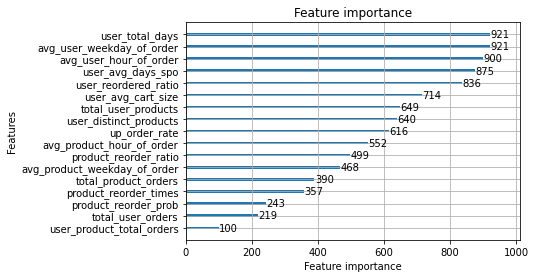

In [71]:
lgb.plot_importance(lgbm)
plt.show()

From feature importances we can get insight, that one of the more important features - are user-related ones, especially - connected with time. Product characteristics play less role.

## Validation

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [53]:
def valid_metrics(y_test, y_pred):
    print(f'Accuracy score: {accuracy_score(y_test, y_pred).round(3)}')
    print(f'Precision score: {precision_score(y_test, y_pred).round(3)}')    
    print(f'Recall score: {recall_score(y_test, y_pred).round(3)}')    
    print(f'F1 score: {f1_score(y_test, y_pred).round(3)}')
    print(f'Roc Auc score: {roc_auc_score(y_test, y_pred).round(3)}')

In [296]:
logreg_pred = logreg_pipe.predict(X_test)
valid_metrics(y_test, logreg_pred)

Accuracy score: 0.773
Precision score: 0.518
Recall score: 0.576
F1 score: 0.545
Roc Auc score: 0.705


In [297]:
tree_pred = tree.predict(X_test)
valid_metrics(y_test, tree_pred)

Accuracy score: 0.773
Precision score: 0.518
Recall score: 0.566
F1 score: 0.541
Roc Auc score: 0.702


In [301]:
rf_pred = rf.predict(X_test)
valid_metrics(y_test, rf_pred)

Accuracy score: 0.803
Precision score: 0.696
Recall score: 0.295
F1 score: 0.415
Roc Auc score: 0.628


In [67]:
lgbm_pred = lgbm.predict(X_test)
valid_metrics(y_test, lgbm_pred)

Accuracy score: 0.77
Precision score: 0.512
Recall score: 0.575
F1 score: 0.542
Roc Auc score: 0.703


## Predicting and submitting

In [45]:
sub = (
    sample_sub
    .assign(
        target = lgbm_pred,
        id = sample_sub.user_id + ';' + sample_sub.product_id
    )
    .drop(['user_id', 'product_id'], axis=1)
)

In [46]:
sub.to_csv('tuned_lgbm_sub.csv', index=False)

## After all

I also tried out a number of ideas that didn't seemed to work out.
1. Assuming, that the order categories are presented in the data, is the order they were added to the cart, feature <i>add to cart order</i> was created.
2. Extra averages for user and product day of month, month.
3. Add order number for each user and create feature <i>user product orders since last order</i>, but it seemed to be data leakage problem, sincee  classifier always returned 1.0 score.
4. Run k-means clustering on users dataset to use customer segments as an extra featue. The problem was, that Within Cluster Sum of Squares curve was very smooth and it seemed like no obvious solution for choosing optimal number of clusters. Anyway, didn't increase final performance.